# HCV
## **Analysis for a dataset with imbalanced data.**

# Preprocessing and Feature Engineering

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, average_precision_score, recall_score, precision_score, f1_score, make_scorer, fbeta_score, matthews_corrcoef
from sklearn.neighbors import KNeighborsClassifier
from sklearn_evaluation import plot
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

sns.set_theme(style = "whitegrid")
%matplotlib inline

In [2]:
# load data
hcv = pd.read_csv('hcv_final.csv')
hcv.head()

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Outcome
0,32,1,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0
1,32,1,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0
2,32,1,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0
3,32,1,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0
4,32,1,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0


In [3]:
# defining the target variable and attributes
y = hcv['Outcome']
x = hcv.drop(['Outcome'], axis = 1)

In [4]:
# cross-validation method
skf = StratifiedKFold(n_splits=5)

## Selection of important features

## Recursive Feature Elimination with Cross-Validation

In [5]:
rfc = RandomForestClassifier(random_state = 45)
model = RFECV(estimator = rfc, cv = skf)
model = model.fit(x, y)

In [6]:
# empty list to which information about important parameters will be added
feature_info = []

for i in range(x.shape[1]):
    ranking = model.ranking_[i]
    feature_info.append({'feature_name': x.columns[i], 'support': model.support_[i], 'ranking': ranking})

# DataFrame to display 
df_features = pd.DataFrame(feature_info)

# Sorting DataFrame
df_features = df_features.sort_values(by='ranking')
df_features

,feature_name,support,ranking
3,ALP,True,1
4,ALT,True,1
5,AST,True,1
10,GGT,False,2
6,BIL,False,3
7,CHE,False,4
8,CHOL,False,5
11,PROT,False,6
9,CREA,False,7
2,ALB,False,8


In [7]:
feat_list = []
included_feats = []
total_importance = 0

# Displaying the most important columns
for feature in zip(x.columns, model.estimator_.feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]
# Display variable name and value by gini index
for feature in zip(x.columns, model.estimator_.feature_importances_):
    if feature[1] > .05:
        included_feats.append(feature[0])         
print('\n',"Total importance =", total_importance.round(2))

# DataFrame to display the results
df_imp = pd.DataFrame(feat_list, columns =['Feature', 'Score']).sort_values(by = 'Score', ascending = False)
df_imp['Importance'] = df_imp['Score'].cumsum()
df_imp


 Total importance = 1.0


,Feature,Score,Importance
2,ALB,0.466786,0.466786
1,Sex,0.267785,0.734571
0,Age,0.265429,1.000000


### According to this method, the most relevant features are: AST, ALP, ALT, ALB, Age.

## ExtraTreesClassifier method

In [8]:
model = ExtraTreesClassifier()
model.fit(x, y)
print(model.feature_importances_)

[0.03375697 0.01152483 0.03356939 0.1415669  0.08303881 0.29022012
 0.08919331 0.0675405  0.05026932 0.04170561 0.11733506 0.04027918]


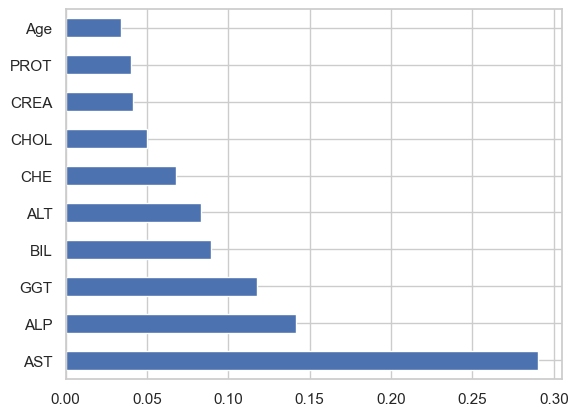

In [9]:
feature_importances = pd.Series(model.feature_importances_, index = x.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.show()

### According to this method, the most relevant features are: AST, ALP, ALT, BIL, GGT. And the least relevant are: Age, CREA, PROT.

## Set new x and y

In [10]:
# defining a new target variable and attributes
y_new = hcv['Outcome']
feature = ['ALT', 'AST', 'ALP', 'ALB', 'Age']
x_new = hcv[feature]
print(x_new)
print(y_new)

       ALT    AST    ALP   ALB  Age
0      7.7   22.1   52.5  38.5   32
1     18.0   24.7   70.3  38.5   32
2     36.2   52.6   74.7  46.9   32
3     30.6   22.6   52.0  43.2   32
4     32.6   24.8   74.1  39.2   32
..     ...    ...    ...   ...  ...
602    5.9  110.3  416.6  32.0   62
603    2.9   44.4  102.8  24.0   64
604    3.5   99.0   87.3  29.0   64
605   39.0   62.0   41.6  33.0   46
606  100.0   80.0   41.6  36.0   59

[607 rows x 5 columns]
0      0
1      0
2      0
3      0
4      0
      ..
602    1
603    1
604    1
605    1
606    1
Name: Outcome, Length: 607, dtype: int64


In [11]:
# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size = 0.2, stratify = y_new, random_state = 16)

# Print the shapes of the resulting sets
print("Training set:", x_train.shape, y_train.shape)
print("Test set:", x_test.shape, y_test.shape)

print("Counts of label '1': {}".format(sum(y_train == 1)))
print("Counts of label '0': {} \n".format(sum(y_train == 0)))

Training set: (485, 5) (485,)
Test set: (122, 5) (122,)
Counts of label '1': 60
Counts of label '0': 425 



In [12]:
# Data standardization
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

# Selection of hyperparameters using cross-validation

In [13]:
np.random.seed(30)

# Classifiers with parameters
classifiers = [
    ('KNN', KNeighborsClassifier(), {
        'classifier__n_neighbors': [3, 5, 7, 10],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__p': [1, 2]
    }),
    ('Random Forest', RandomForestClassifier(), {
       'classifier__n_estimators': list(range(10, 51, 10)),
       'classifier__criterion': ['gini', 'entropy'],
       'classifier__max_depth': [1, 2, 3, 4, 5, 10],
      'classifier__min_samples_split': list(range(2, 4)),
      'classifier__min_samples_leaf': list(range(2, 4))
    }),
    ('NB', GaussianNB(), {
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
    }),
    ('LogR', LogisticRegression(max_iter=2000), {
       'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
       'classifier__penalty': ['l1', 'l2'],
       'classifier__solver': ['liblinear', 'saga']
    }),
    ('SVM', SVC(probability=True), {
       'classifier__C': [0.1, 1, 10, 100, 1000],
       'classifier__kernel': ['linear', 'rbf'],
       'classifier__gamma': [0.0001, 0.001, 0.01, 0.1, 1]
    }),
    ('XGBoost', XGBClassifier(), {
        'classifier__max_depth': [2, 3, 4, 6],
        'classifier__gamma': [0, 0.4, 0.8],
        'classifier__learning_rate': [0.01, 0.1, 0.3, 0.4, 0.5],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__reg_lambda': [0, 0.1, 1],
        'classifier__reg_alpha': [0.1, 1]
    }),
    ('CART', DecisionTreeClassifier(), {
        'classifier__criterion'         : ['gini', 'entropy'],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__max_depth'         : [2,4,6,8,10,12],
        'classifier__min_samples_split' : list(range(2,10)),
        'classifier__min_samples_leaf'  : list(range(1,10))
    })
]

# Pipeline with classifiers
classifier_pipeline = Pipeline([
    ('classifier', KNeighborsClassifier()) # classifier will be replaced with the appropriate classifier during data flow
])

# Metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=1),
    'recall': make_scorer(recall_score, zero_division=1),
    'f1': make_scorer(f1_score),
    'f2': make_scorer(fbeta_score, beta=2),
    'specificity': make_scorer(
        lambda y_true, y_pred:
        recall_score(y_true, y_pred, pos_label=0)),
    'mcc': make_scorer(matthews_corrcoef),
    'sensitivity': make_scorer(recall_score)
} 


In [14]:
# Display results
best_classifiers = []
for name, clf, param in classifiers:
    classifier_pipeline.set_params(classifier=clf)
    # Grid Search
    search = GridSearchCV(estimator=classifier_pipeline, param_grid=param, cv=skf, scoring=scoring, refit='recall', n_jobs=-1, verbose=1)
    search.fit(x_new, y_new)
    print(f"Best parameters for {name} (Grid Search):", search.best_params_)
    print(f"Best estimator for {name} (Grid Search):", search.best_estimator_)
    print(f"Best scores for {name} (Grid Search):", search.best_score_)
    # Randomized Search
    random_search = RandomizedSearchCV(estimator=classifier_pipeline, param_distributions=param, n_iter=9, scoring=scoring, refit="recall", n_jobs=-1, return_train_score=True, cv=skf, verbose=1)
    random_search.fit(x_new, y_new)
    print(f"Best parameters for {name} (Randomized Search):", random_search.best_params_)
    print(f"Best estimator for {name} (Randomized Search):", random_search.best_estimator_)

    best_classifiers.append((name, search.best_estimator_))
    best_classifiers.append((name, random_search.best_estimator_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


Best parameters for KNN (Grid Search): {'classifier__n_neighbors': 3, 'classifier__p': 1, 'classifier__weights': 'uniform'}
Best estimator for KNN (Grid Search): Pipeline(steps=[('classifier', KNeighborsClassifier(n_neighbors=3, p=1))])
Best scores for KNN (Grid Search): 0.76
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for KNN (Randomized Search): {'classifier__weights': 'uniform', 'classifier__p': 1, 'classifier__n_neighbors': 3}
Best estimator for KNN (Randomized Search): Pipeline(steps=[('classifier', KNeighborsClassifier(n_neighbors=3, p=1))])
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters for Random Forest (Grid Search): {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 30}
Best estimator for Random Forest (Grid Search): Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=10, mi

In [15]:
classifier_param = []
for name, estimator in best_classifiers:
    classifier_param.append({
        'Classifier': name,
        'Best Parameters': str(estimator.named_steps['classifier'].get_params()),  
})

# DataFrame to display
df_classifier_param = pd.DataFrame(classifier_param)
pd.set_option('display.max_colwidth', None)
df_classifier_param

,Classifier,Best Parameters
0,KNN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}"
1,KNN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}"
2,Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 30, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
3,Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}"
4,NB,"{'priors': None, 'var_smoothing': 1e-09}"
5,NB,"{'priors': None, 'var_smoothing': 1e-09}"
6,LogR,"{'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 2000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}"
7,LogR,"{'C': 100, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 2000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}"
8,SVM,"{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"
9,SVM,"{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.0001, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}"


In [16]:
# Metrics for best estimators
# checking whether to select results from GridSearch or RandomSearch
# list for collecting metrics results
metrics_data = []


for name, estimator in best_classifiers:
    estimator.fit(x_new, y_new)
    y_pred = estimator.predict(x_new)
    
    # Metrics
    accuracy = round(accuracy_score(y_new, y_pred), 2)
    precision = round(precision_score(y_new, y_pred), 2)
    recall = round(recall_score(y_new, y_pred), 2)
    f1 = round(f1_score(y_new, y_pred), 2)
    f2 = round(fbeta_score(y_new, y_pred, beta=2), 2)
    specificity = round(recall_score(y_new, y_pred, pos_label=0), 2)
    sensitivity = round(recall_score(y_new, y_pred, pos_label=1), 2)
    mcc = round(matthews_corrcoef(y_new, y_pred), 2)
    
    metrics_dict = {
        'Classifier': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'F2': f2,
        'Specificity': specificity,
        'Sensitivity': sensitivity,
        'MCC': mcc,
    }
    
    metrics_data.append(metrics_dict)

# DataFrame for metrics
metrics_df = pd.DataFrame(metrics_data)
pd.set_option('display.max_columns', None) 
metrics_df

,Classifier,Accuracy,Precision,Recall,F1,F2,Specificity,Sensitivity,MCC
0,KNN,0.98,0.93,0.91,0.92,0.91,0.99,0.91,0.91
1,KNN,0.98,0.93,0.91,0.92,0.91,0.99,0.91,0.91
2,Random Forest,1.00,0.99,0.99,0.99,0.99,1.00,0.99,0.98
3,Random Forest,0.99,0.97,0.95,0.96,0.95,1.00,0.95,0.95
4,NB,0.93,0.78,0.60,0.68,0.63,0.98,0.60,0.64
5,NB,0.93,0.78,0.60,0.68,0.63,0.98,0.60,0.64
6,LogR,0.94,0.90,0.61,0.73,0.66,0.99,0.61,0.72
7,LogR,0.94,0.90,0.61,0.73,0.66,0.99,0.61,0.72
8,SVM,0.99,0.97,0.92,0.95,0.93,1.00,0.92,0.94
9,SVM,0.98,0.94,0.89,0.92,0.90,0.99,0.89,0.91


## Once again calculated metrics for models with the best parameters in order to get rid of overfitting (I am making a new cross-val) and to pre-evaluate the models

In [17]:
np.random.seed(35)
# Classifiers
models = [
    ('KNN', KNeighborsClassifier(n_neighbors = 7, p = 1, weights = 'distance')),
    ('RF', RandomForestClassifier(criterion = 'entropy', max_depth = 4, min_samples_leaf = 2, min_samples_split = 3, n_estimators = 10, max_features = 'sqrt')),
    ('CART', DecisionTreeClassifier(min_samples_split = 3, min_samples_leaf = 9, max_features = 'log2', max_depth = 2, criterion = 'entropy')),
    ('NB', GaussianNB(var_smoothing = 1e-09)),
    ('LogR', LogisticRegression(C = 1, penalty = 'l2', solver = 'liblinear')),
    ('SVM', SVC(probability=True, C=1000, gamma=0.0001, kernel='linear')),
    ('XGB', XGBClassifier(reg_lambda = 0.1, reg_alpha = 1, n_estimators = 100, max_depth = 4, learning_rate = 0.4, gamma = 0))]

# Metrics
cv_scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'f2': make_scorer(fbeta_score, beta=2),
    'specificity': make_scorer(
        lambda y_true, y_pred:
        recall_score(y_true, y_pred, pos_label=0)),
    'sensitivity': make_scorer(recall_score, pos_label=1),
    'mcc': make_scorer(matthews_corrcoef)}

# Empty DataFrame to collect results
results_cross_val_xy = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1', 'F2', 'Specificity', 'MCC', 'Sensitivity'])
result = []
names = []

# Apply cross-val for all classifiers
for name, model in models:
    results = cross_validate(model, x_new, y_new, cv = skf, scoring=cv_scoring, return_estimator=True)
    df = pd.DataFrame({
        'Classifier': [name],
        'Accuracy': [round(results['test_accuracy'].mean(), 2)],
        'Precision': [round(results['test_precision'].mean(), 2)],
        'Recall': [round(results['test_recall'].mean(), 2)],
        'F1': [round(results['test_f1'].mean(), 2)],
        'F2': [round(results['test_f2'].mean(), 2)],
        'Specificity': [round(results['test_specificity'].mean(), 2)],
        'Sensitivity': [round(results['test_sensitivity'].mean(), 2)],
        'MCC': [round(results['test_mcc'].mean(), 2)]})
    results_cross_val_xy = pd.concat([results_cross_val_xy, df], ignore_index=True)
    result.append(results)
    names.append(name)

results_cross_val_xy = results_cross_val_xy.sort_values(by='F2', ascending=False) # Sorting for the F2 metric
results_cross_val_xy = results_cross_val_xy.reset_index(drop=True) # Reset index
results_cross_val_xy # Display DataFrame

,Classifier,Accuracy,Precision,Recall,F1,F2,Specificity,MCC,Sensitivity
0,XGB,0.98,0.94,0.91,0.92,0.91,0.99,0.91,0.91
1,RF,0.96,0.91,0.77,0.83,0.79,0.99,0.81,0.77
2,KNN,0.96,0.92,0.73,0.81,0.76,0.99,0.80,0.73
3,SVM,0.95,0.91,0.67,0.76,0.70,0.99,0.75,0.67
4,LogR,0.95,0.94,0.61,0.73,0.65,0.99,0.73,0.61
5,CART,0.92,0.75,0.63,0.65,0.63,0.96,0.63,0.63
6,NB,0.93,0.79,0.61,0.67,0.63,0.97,0.65,0.61


## Preliminary evaluation:
## Top 3 best models:
## 1. XGB
## 2. RF
## 3. CART 
## Top 3 weakest models:
## 1. SVM
## 2. KNN
## 3. NB

(array([1, 2, 3, 4, 5, 6, 7]),
 [Text(1, 0, 'KNN'),
  Text(2, 0, 'RF'),
  Text(3, 0, 'CART'),
  Text(4, 0, 'NB'),
  Text(5, 0, 'LogR'),
  Text(6, 0, 'SVM'),
  Text(7, 0, 'XGB')])

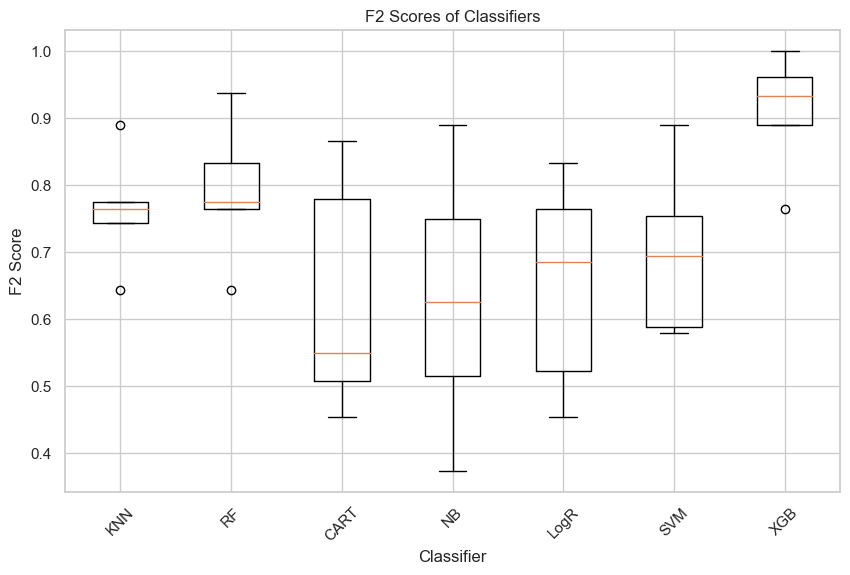

In [18]:
# F2 score - boxplot
f2_scores = [result['test_f2'] for result in result]
plt.figure(figsize=(10, 6))
plt.boxplot(f2_scores, labels=names)
plt.title('F2 Scores of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('F2 Score')
plt.xticks(rotation=45)

In [19]:
np.random.seed(42) 

# Model Training and Evaluation: 

## 1. KNeighborsClassifier

In [20]:
knn = KNeighborsClassifier(n_neighbors = 3, p = 1, weights = 'uniform')
model_knn = knn.fit(x_train, y_train) # model training
y_pred_knn_train = model_knn.predict(x_train) # prediction for the training set

In [21]:
# prediction on the test set
y_pred_val_knn = model_knn.predict(x_test)
y_pred_proba_val_knn = model_knn.predict_proba(x_test)[:, 1]

In [22]:
# Metrics for the test set
accuracy_test = accuracy_score(y_test, y_pred_val_knn)
report_val = classification_report(y_test, y_pred_val_knn)
cm_val = confusion_matrix(y_test, y_pred_val_knn)
roc_auc_val = roc_auc_score(y_test, y_pred_proba_val_knn)
precision_val = precision_score(y_test, y_pred_val_knn)
f1_val = f1_score(y_test, y_pred_val_knn, average = 'weighted')
f2_val = fbeta_score(y_test, y_pred_val_knn, beta=2.0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_val_knn).ravel()
specificity_test = tn / (tn + fp)
sensitivity_test = tp / (tp + fn)
mcc_val = matthews_corrcoef(y_test, y_pred_val_knn)

print("Accuracy :", accuracy_test.round(2))
print("Classification Report :\n", report_val)
print("Confusion Matrix :\n", cm_val)
print("ROC AUC:", roc_auc_val.round(2))
print("Precision:", precision_val.round(2))
print("F1 Score:", f1_val.round(2))
print("F2 Score:", f2_val.round(2))
print("Specificity:", specificity_test.round(2))
print("Sensitivity:", sensitivity_test.round(2))
print("MCC:", mcc_val.round(2))

Accuracy : 0.96
Classification Report :
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       107
           1       0.86      0.80      0.83        15

    accuracy                           0.96       122
   macro avg       0.91      0.89      0.90       122
weighted avg       0.96      0.96      0.96       122

Confusion Matrix :
 [[105   2]
 [  3  12]]
ROC AUC: 0.96
Precision: 0.86
F1 Score: 0.96
F2 Score: 0.81
Specificity: 0.98
Sensitivity: 0.8
MCC: 0.8


In [23]:
print('Report: training set \n', classification_report(y_train, y_pred_knn_train))
print('\n Report: test set \n', classification_report(y_test, y_pred_val_knn))

Report: training set 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       425
           1       0.95      0.88      0.91        60

    accuracy                           0.98       485
   macro avg       0.97      0.94      0.95       485
weighted avg       0.98      0.98      0.98       485


 Report: test set 
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       107
           1       0.86      0.80      0.83        15

    accuracy                           0.96       122
   macro avg       0.91      0.89      0.90       122
weighted avg       0.96      0.96      0.96       122



AUC: 0.96


Text(0.5, 1.0, 'KNeighborsClassifier Model ROC curve; AUC: 0.96')

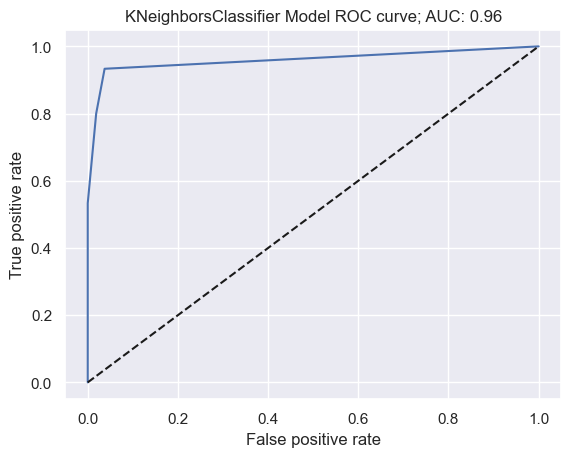

In [24]:
# AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_val_knn)
auc_knn = np.round(roc_auc_score(y_test, y_pred_proba_val_knn), 2)
print("AUC:", auc_knn) 

sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'KNeighborsClassifier Model ROC curve; AUC: {auc_knn}')

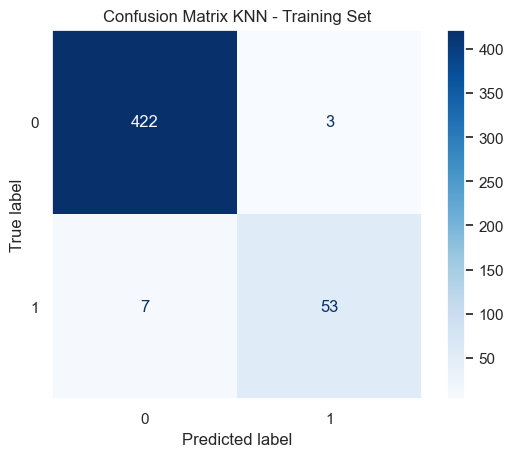

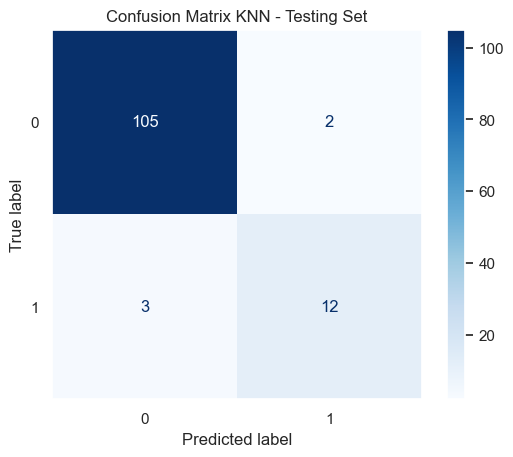

In [25]:
# Confusion matrix for the training set
confusion_display_train = ConfusionMatrixDisplay.from_predictions(y_train, y_pred_knn_train, cmap=plt.cm.Blues)
confusion_display_train.ax_.set_title('Confusion Matrix KNN - Training Set')
plt.grid(False)

# Confusion matrix for the test set
confusion_display_test = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_val_knn, cmap=plt.cm.Blues)
confusion_display_test.ax_.set_title('Confusion Matrix KNN - Testing Set')
plt.grid(False)

## 2. RandomForestClassifier

In [26]:
rfc = RandomForestClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 3, min_samples_leaf = 3, min_samples_split = 2, n_estimators = 10, max_features = 'sqrt')
model_rfc = rfc.fit(x_train, y_train) # model training
y_pred_rfc_train = model_rfc.predict(x_train) # prediction for the training set

In [27]:
# Prediction on the test set
y_pred_val_rfc = model_rfc.predict(x_test)
y_pred_proba_val_rfc = model_rfc.predict_proba(x_test)[:, 1]

In [28]:
# Metrics for the test set
accuracy_test = accuracy_score(y_test, y_pred_val_rfc)
report_val = classification_report(y_test, y_pred_val_rfc)
cm_val = confusion_matrix(y_test, y_pred_val_rfc)
roc_auc_val = roc_auc_score(y_test, y_pred_proba_val_rfc)
precision_val = precision_score(y_test, y_pred_val_rfc)
f1_val = f1_score(y_test, y_pred_val_rfc, average = 'weighted')
f2_val = fbeta_score(y_test, y_pred_val_rfc, beta=2.0)
mcc_val = matthews_corrcoef(y_test, y_pred_val_rfc)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_val_rfc).ravel()
sensitivity_test = tp / (tp + fn)
specificity_test = tn / (tn + fp)

print("Accuracy:", accuracy_test.round(2))
print("Classification Report:\n", report_val)
print("Confusion Matrix:\n", cm_val)
print("ROC AUC:", roc_auc_val.round(2))
print("Precision:", precision_val.round(2))
print("F1 Score:", f1_val.round(2))
print("F2 Score:", f2_val.round(2))
print("Specificity:", specificity_test.round(2))
print("Sensitivity:", sensitivity_test.round(2))
print("MCC", mcc_val.round(2))

Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       107
           1       0.93      0.93      0.93        15

    accuracy                           0.98       122
   macro avg       0.96      0.96      0.96       122
weighted avg       0.98      0.98      0.98       122

Confusion Matrix:
 [[106   1]
 [  1  14]]
ROC AUC: 0.95
Precision: 0.93
F1 Score: 0.98
F2 Score: 0.93
Specificity: 0.99
Sensitivity: 0.93
MCC 0.92


In [29]:
print('Report: training set \n', classification_report(y_train, y_pred_rfc_train))
print('\n Report: test set \n', classification_report(y_test, y_pred_val_rfc))

Report: training set 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       425
           1       0.92      0.98      0.95        60

    accuracy                           0.99       485
   macro avg       0.96      0.99      0.97       485
weighted avg       0.99      0.99      0.99       485


 Report: test set 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       107
           1       0.93      0.93      0.93        15

    accuracy                           0.98       122
   macro avg       0.96      0.96      0.96       122
weighted avg       0.98      0.98      0.98       122



AUC: 0.95


Text(0.5, 1.0, 'RF Model ROC curve; AUC: 0.95')

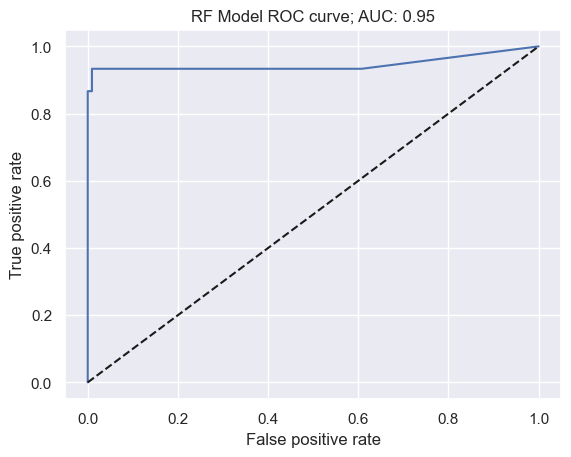

In [30]:
# AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_val_rfc)
auc_rfc = np.round(roc_auc_score(y_test, y_pred_proba_val_rfc), 2)
print("AUC:", auc_rfc) 

sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'RF Model ROC curve; AUC: {auc_rfc}')

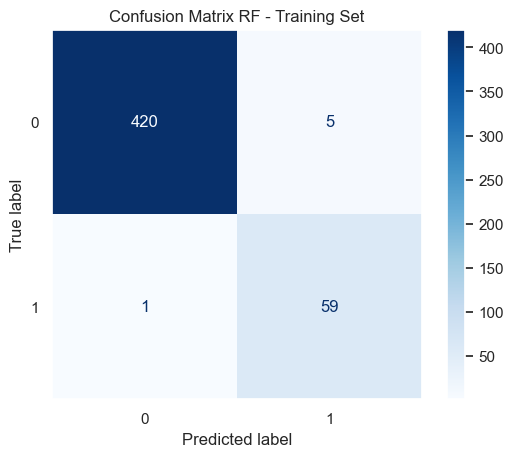

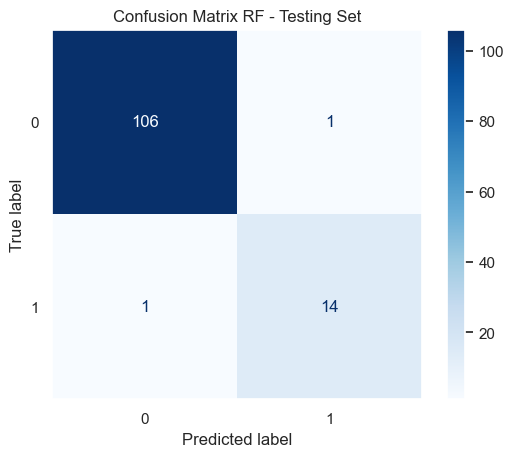

In [31]:
# Confusion matrix for the training set
confusion_display_train = ConfusionMatrixDisplay.from_predictions(y_train, y_pred_rfc_train, cmap = plt.cm.Blues)
confusion_display_train.ax_.set_title('Confusion Matrix RF - Training Set')
plt.grid(False)

# Confusion matrix for the test set
confusion_display_test = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_val_rfc, cmap = plt.cm.Blues)
confusion_display_test.ax_.set_title('Confusion Matrix RF - Testing Set')
plt.grid(False)

### 3. Decision Tree Classifier

In [32]:
dtc = DecisionTreeClassifier(class_weight = 'balanced', min_samples_split = 3, min_samples_leaf = 3, max_features = 'sqrt', max_depth = 10, criterion = 'entropy')
model_dtc = dtc.fit(x_train, y_train) # training the model
y_pred_dtc_train = model_dtc.predict(x_train)

In [33]:
# Prediction on the test set
y_pred_val_dtc = model_dtc.predict(x_test)
y_pred_proba_val_dtc = model_dtc.predict_proba(x_test)[:, 1]

In [34]:
# Metrics for the test set
accuracy_test = accuracy_score(y_test, y_pred_val_dtc)
report_val = classification_report(y_test, y_pred_val_dtc, zero_division = 1)
cm_val = confusion_matrix(y_test, y_pred_val_dtc)
roc_auc_val = roc_auc_score(y_test, y_pred_proba_val_dtc)
precision_val = precision_score(y_test, y_pred_val_dtc, zero_division = 1)
f1_val = f1_score(y_test, y_pred_val_dtc, average = 'weighted')
f2_val = fbeta_score(y_test, y_pred_val_dtc, beta = 2.0)
mcc_val = matthews_corrcoef(y_test, y_pred_val_dtc)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_val_dtc).ravel()
specificity_test = tn / (tn + fp)
sensitivity_test = tp / (tp + fn)

print("Accuracy:", accuracy_test.round(2))
print("Classification Report:\n", report_val)
print("Confusion Matrix:\n", cm_val)
print("ROC AUC:", roc_auc_val.round(2))
print("Precision:", precision_val.round(2))
print("F1 Score:", f1_val.round(2))
print("F2 Score:", f2_val.round(2))
print("MCC:", mcc_val.round(2))
print("Specificity:", specificity_test.round(2))
print("Sensitivity:", sensitivity_test.round(2))

Accuracy: 0.97
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       107
           1       0.82      0.93      0.87        15

    accuracy                           0.97       122
   macro avg       0.91      0.95      0.93       122
weighted avg       0.97      0.97      0.97       122

Confusion Matrix:
 [[104   3]
 [  1  14]]
ROC AUC: 0.96
Precision: 0.82
F1 Score: 0.97
F2 Score: 0.91
MCC: 0.86
Specificity: 0.97
Sensitivity: 0.93


In [35]:
print('Report: training set \n', classification_report(y_train, y_pred_dtc_train))
print('\n Report: test set\n', classification_report(y_test, y_pred_val_dtc))

Report: training set 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       425
           1       0.86      1.00      0.92        60

    accuracy                           0.98       485
   macro avg       0.93      0.99      0.96       485
weighted avg       0.98      0.98      0.98       485


 Report: test set 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       107
           1       0.82      0.93      0.87        15

    accuracy                           0.97       122
   macro avg       0.91      0.95      0.93       122
weighted avg       0.97      0.97      0.97       122



[Text(0.43, 0.9166666666666666, 'AST <= 0.047\nentropy = 1.0\nsamples = 485\nvalue = [242.5, 242.5]'),
 Text(0.18, 0.75, 'AST <= -0.123\nentropy = 0.418\nsamples = 388\nvalue = [218.535, 20.208]'),
 Text(0.08, 0.5833333333333334, 'ALT <= -0.925\nentropy = 0.251\nsamples = 325\nvalue = [184.3, 8.083]'),
 Text(0.04, 0.4166666666666667, 'entropy = 0.351\nsamples = 3\nvalue = [0.571, 8.083]'),
 Text(0.12, 0.4166666666666667, 'entropy = -0.0\nsamples = 322\nvalue = [183.729, 0.0]'),
 Text(0.28, 0.5833333333333334, 'ALB <= -0.451\nentropy = 0.829\nsamples = 63\nvalue = [34.235, 12.125]'),
 Text(0.2, 0.4166666666666667, 'ALT <= 0.907\nentropy = 0.978\nsamples = 12\nvalue = [5.706, 8.083]'),
 Text(0.16, 0.25, 'ALB <= -0.478\nentropy = 0.916\nsamples = 9\nvalue = [3.994, 8.083]'),
 Text(0.12, 0.08333333333333333, 'entropy = 0.0\nsamples = 6\nvalue = [3.424, 0.0]'),
 Text(0.2, 0.08333333333333333, 'entropy = 0.351\nsamples = 3\nvalue = [0.571, 8.083]'),
 Text(0.24, 0.25, 'entropy = 0.0\nsamples 

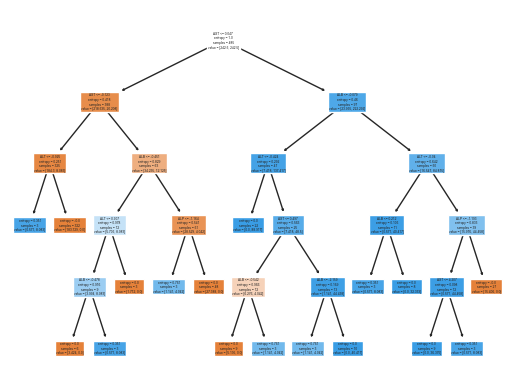

In [36]:
# Decision tree
tree.plot_tree(dtc, feature_names = feature, filled = True)

AUC: 0.96


Text(0.5, 1.0, 'DecisionTree Model ROC curve; AUC: 0.96')

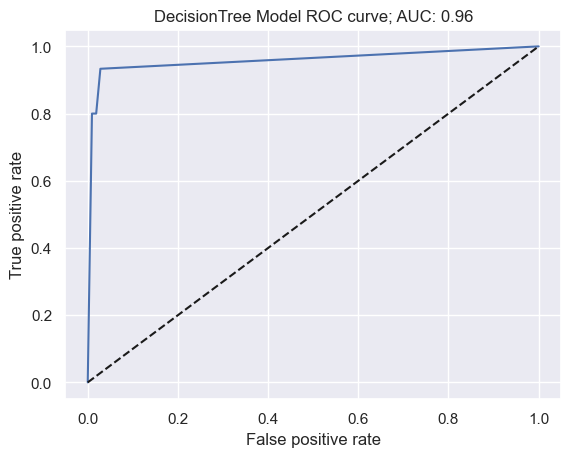

In [37]:
# AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_val_dtc)
auc_dtc = np.round(roc_auc_score(y_test, y_pred_proba_val_dtc), 2)
print("AUC:", auc_dtc) 

sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'DecisionTree Model ROC curve; AUC: {auc_dtc}')

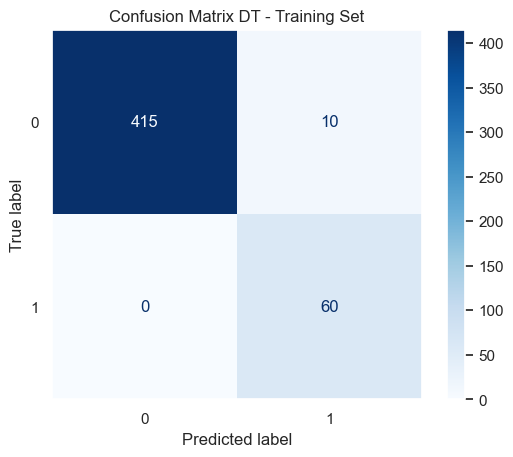

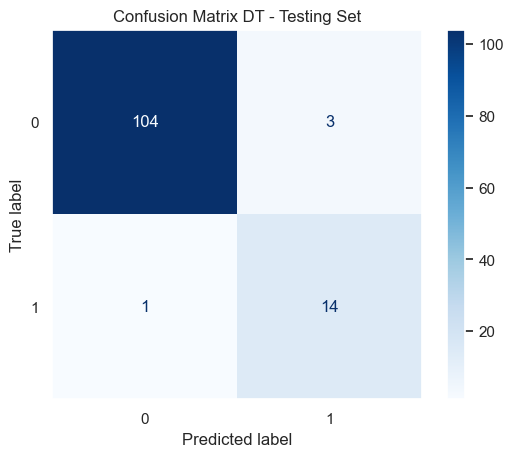

In [38]:
# Confusion matrix for the training set
confusion_display_train = ConfusionMatrixDisplay.from_predictions(y_train, y_pred_dtc_train, cmap = plt.cm.Blues)
confusion_display_train.ax_.set_title('Confusion Matrix DT - Training Set')
plt.grid(False)

# Confusion matrix for the test set
confusion_display_test = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_val_dtc, cmap = plt.cm.Blues)
confusion_display_test.ax_.set_title('Confusion Matrix DT - Testing Set')
plt.grid(False)

## 4. Naive Bayes

In [39]:
gnb = GaussianNB(var_smoothing = 1e-09)
model_gnb = gnb.fit(x_train, y_train)
y_pred_gnb_train = model_gnb.predict(x_train)

In [40]:
# Prediction on the test set
y_pred_val_gnb = model_gnb.predict(x_test)
y_pred_proba_val_gnb = model_gnb.predict_proba(x_test)[:, 1]

In [41]:
# Metrics for the test set
accuracy_test = accuracy_score(y_test, y_pred_val_gnb)
report_val = classification_report(y_test, y_pred_val_gnb)
cm_val = confusion_matrix(y_test, y_pred_val_gnb)
roc_auc_val = roc_auc_score(y_test, y_pred_proba_val_gnb)
precision_val = precision_score(y_test, y_pred_val_gnb)
f1_val = f1_score(y_test, y_pred_val_gnb, average = 'weighted')
f2_val = fbeta_score(y_test, y_pred_val_gnb, beta = 2.0)
mcc_val = matthews_corrcoef(y_test, y_pred_val_gnb)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_val_gnb).ravel()
specificity_test = tn / (tn + fp)
sensitivity_test = tp / (tp + fn)

print("Accuracy:", accuracy_test.round(2))
print("Classification Report:\n", report_val)
print("Confusion Matrix:\n", cm_val)
print("ROC AUC:", roc_auc_val.round(2))
print("Precision:", precision_val.round(2))
print("F1 Score:", f1_val.round(2))
print("F2 Score:", f2_val.round(2))
print("MCC:", mcc_val.round(2))
print("Specificity:", specificity_test.round(2))
print("Sensitivity:", sensitivity_test.round(2))

Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95       107
           1       0.61      0.73      0.67        15

    accuracy                           0.91       122
   macro avg       0.79      0.83      0.81       122
weighted avg       0.92      0.91      0.91       122

Confusion Matrix:
 [[100   7]
 [  4  11]]
ROC AUC: 0.93
Precision: 0.61
F1 Score: 0.91
F2 Score: 0.71
MCC: 0.62
Specificity: 0.93
Sensitivity: 0.73


In [42]:
print('Report: training set \n', classification_report(y_train, y_pred_gnb_train))
print('\n Report: test set \n', classification_report(y_test, y_pred_val_gnb))

Report: training set 
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       425
           1       0.80      0.60      0.69        60

    accuracy                           0.93       485
   macro avg       0.87      0.79      0.82       485
weighted avg       0.93      0.93      0.93       485


 Report: test set 
               precision    recall  f1-score   support

           0       0.96      0.93      0.95       107
           1       0.61      0.73      0.67        15

    accuracy                           0.91       122
   macro avg       0.79      0.83      0.81       122
weighted avg       0.92      0.91      0.91       122



AUC: 0.93


Text(0.5, 1.0, 'Naive Bayes Model ROC curve; AUC: 0.93')

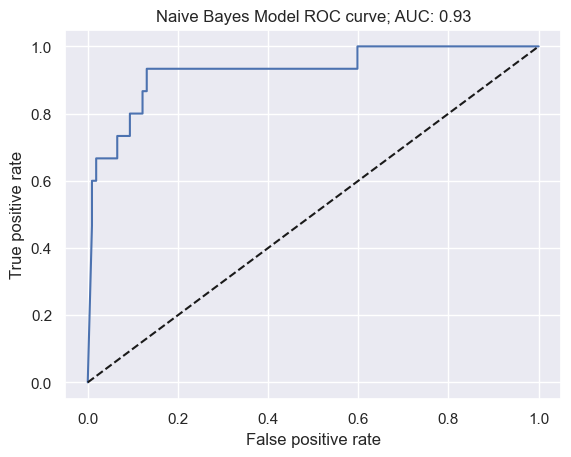

In [43]:
# AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_val_gnb)
auc_nb = np.round(roc_auc_score(y_test, y_pred_proba_val_gnb), 2)
print("AUC:", auc_nb) 

sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'Naive Bayes Model ROC curve; AUC: {auc_nb}')

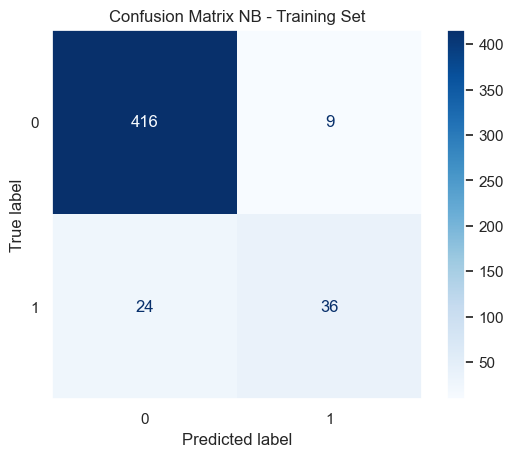

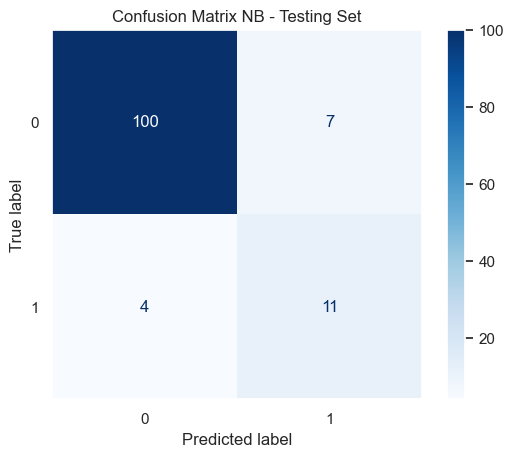

In [44]:
# Confusion matrix for the training set
confusion_display_train = ConfusionMatrixDisplay.from_predictions(y_train, y_pred_gnb_train, cmap = plt.cm.Blues)
confusion_display_train.ax_.set_title('Confusion Matrix NB - Training Set')
plt.grid(False)

# Confusion matrix for the test set
confusion_display_test = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_val_gnb, cmap = plt.cm.Blues)
confusion_display_test.ax_.set_title('Confusion Matrix NB - Testing Set')
plt.grid(False)

## 5. Logistic Regression

In [45]:
lr = LogisticRegression(max_iter = 2000, class_weight = 'balanced', C = 100, penalty = 'l1', solver = 'liblinear')
model_lr = lr.fit(x_train, y_train)
y_pred_lr_train = model_lr.predict(x_train)

In [46]:
# Prediction on the test set
y_pred_val_lr = model_lr.predict(x_test)
y_pred_proba_val_lr = model_lr.predict_proba(x_test)[:, 1]

In [47]:
# Metrics for the test set
accuracy_test = accuracy_score(y_test, y_pred_val_lr)
report_val = classification_report(y_test, y_pred_val_lr)
cm_val = confusion_matrix(y_test, y_pred_val_lr)
roc_auc_val = roc_auc_score(y_test, y_pred_proba_val_lr)
precision_val = precision_score(y_test, y_pred_val_lr)
f1_val = f1_score(y_test, y_pred_val_lr, average = 'weighted')
f2_val = fbeta_score(y_test, y_pred_val_lr, beta = 2.0)
mcc_val = matthews_corrcoef(y_test, y_pred_val_lr)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_val_lr).ravel()
specificity_test = tn / (tn + fp)
sensitivity_test = tp / (tp + fn)

print("Accuracy:", accuracy_test.round(2))
print("Classification Report:\n", report_val)
print("Confusion Matrix:\n", cm_val)
print("ROC AUC:", roc_auc_val.round(2))
print("Precision:", precision_val.round(2))
print("F1 Score:", f1_val.round(2))
print("F2 Score:", f2_val.round(2))
print("MCC:", mcc_val.round(2))
print("Specificity:", specificity_test.round(2))
print("Sensitivity:", sensitivity_test.round(2))

Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       107
           1       0.75      0.80      0.77        15

    accuracy                           0.94       122
   macro avg       0.86      0.88      0.87       122
weighted avg       0.94      0.94      0.94       122

Confusion Matrix:
 [[103   4]
 [  3  12]]
ROC AUC: 0.87
Precision: 0.75
F1 Score: 0.94
F2 Score: 0.79
MCC: 0.74
Specificity: 0.96
Sensitivity: 0.8


In [48]:
print('Report: training set \n', classification_report(y_train, y_pred_lr_train))
print('\n Report: test set \n', classification_report(y_test, y_pred_val_lr))

Report: training set 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       425
           1       0.72      0.90      0.80        60

    accuracy                           0.94       485
   macro avg       0.85      0.93      0.88       485
weighted avg       0.95      0.94      0.95       485


 Report: test set 
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       107
           1       0.75      0.80      0.77        15

    accuracy                           0.94       122
   macro avg       0.86      0.88      0.87       122
weighted avg       0.94      0.94      0.94       122



AUC: 0.87


Text(0.5, 1.0, 'Logistic Regression Model ROC curve; AUC: 0.87')

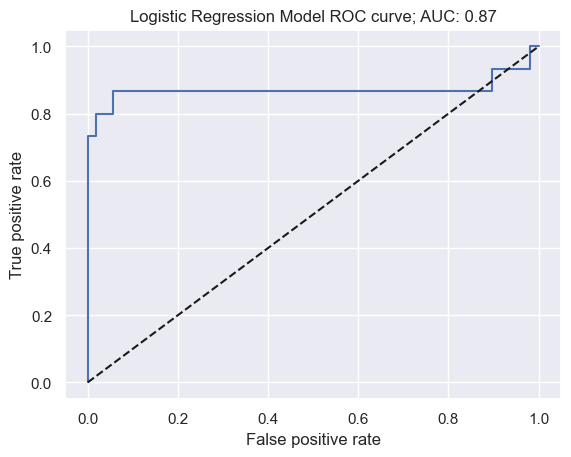

In [49]:
# AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_val_lr)
auc_lr = np.round(roc_auc_score(y_test, y_pred_proba_val_lr), 2)
print("AUC:", auc_lr) 

sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'Logistic Regression Model ROC curve; AUC: {auc_lr}')

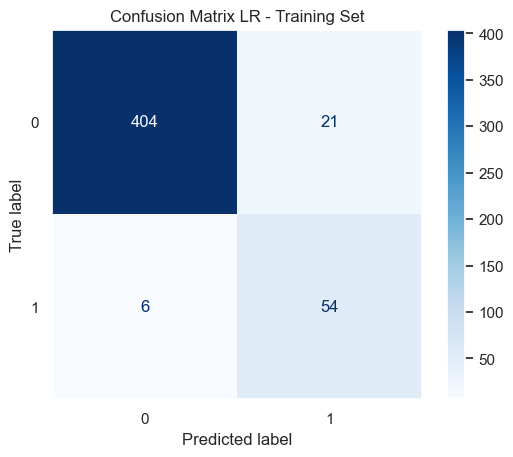

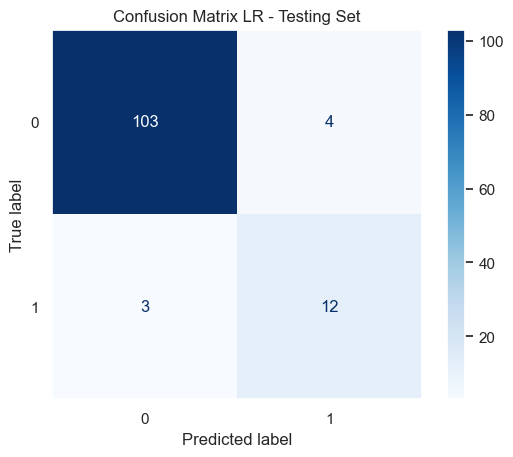

In [50]:
# Confusion matrix for the training set
confusion_display_train = ConfusionMatrixDisplay.from_predictions(y_train, y_pred_lr_train, cmap = plt.cm.Blues)
confusion_display_train.ax_.set_title('Confusion Matrix LR - Training Set')
plt.grid(False)

# Confusion matrix for the test set
confusion_display_test = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_val_lr, cmap = plt.cm.Blues)
confusion_display_test.ax_.set_title('Confusion Matrix LR - Testing Set')
plt.grid(False)

## 6. SVM

In [51]:
svc = SVC(probability=True, C = 1000, class_weight = 'balanced', gamma = 0.0001, kernel = 'linear')
model_svc = svc.fit(x_train, y_train)
y_pred_svc_train = model_svc.predict(x_train)

In [52]:
# Prediction on the test set
y_pred_val_svc = model_svc.predict(x_test)
y_pred_proba_val_svc = model_svc.predict_proba(x_test)[:, 1]

In [53]:
# Metrics for the test set
accuracy_test = accuracy_score(y_test, y_pred_val_svc)
report_val = classification_report(y_test, y_pred_val_svc)
cm_val = confusion_matrix(y_test, y_pred_val_svc)
roc_auc_val = roc_auc_score(y_test, y_pred_proba_val_svc)
precision_val = precision_score(y_test, y_pred_val_svc)
f1_val = f1_score(y_test, y_pred_val_svc, average = 'weighted')
f2_val = fbeta_score(y_test, y_pred_val_svc, beta = 2.0)
mcc_val = matthews_corrcoef(y_test, y_pred_val_svc)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_val_svc).ravel()
specificity_test = tn / (tn + fp)
sensitivity_test = tp / (tp + fn)

print("Accuracy:", accuracy_test.round(2))
print("Classification Report:\n", report_val)
print("Confusion Matrix:\n", cm_val)
print("ROC AUC:", roc_auc_val.round(2))
print("Precision:", precision_val.round(2))
print("F1 Score:", f1_val.round(2))
print("F2 Score:", f2_val.round(2))
print("MCC:", mcc_val.round(2))
print("Specificity:", specificity_test.round(2))
print("Sensitivity:", sensitivity_test.round(2)) 

Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       107
           1       0.80      0.80      0.80        15

    accuracy                           0.95       122
   macro avg       0.89      0.89      0.89       122
weighted avg       0.95      0.95      0.95       122

Confusion Matrix:
 [[104   3]
 [  3  12]]
ROC AUC: 0.9
Precision: 0.8
F1 Score: 0.95
F2 Score: 0.8
MCC: 0.77
Specificity: 0.97
Sensitivity: 0.8


In [54]:
print('Report: training set \n', classification_report(y_train, y_pred_svc_train))
print('\n Report: test set \n', classification_report(y_test, y_pred_val_svc))

Report: training set 
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       425
           1       0.71      0.92      0.80        60

    accuracy                           0.94       485
   macro avg       0.85      0.93      0.89       485
weighted avg       0.95      0.94      0.95       485


 Report: test set 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       107
           1       0.80      0.80      0.80        15

    accuracy                           0.95       122
   macro avg       0.89      0.89      0.89       122
weighted avg       0.95      0.95      0.95       122



AUC: 0.9


Text(0.5, 1.0, 'SVC Model ROC curve; AUC: 0.9')

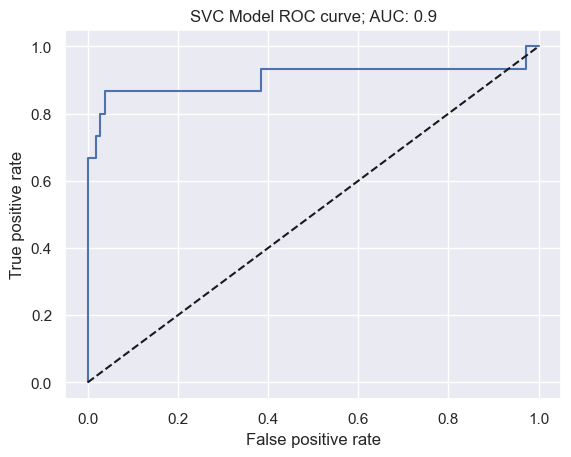

In [55]:
# AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_val_svc)
auc_svc = np.round(roc_auc_score(y_test, y_pred_proba_val_svc), 2)
print("AUC:", auc_svc) 

sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'SVC Model ROC curve; AUC: {auc_svc}')

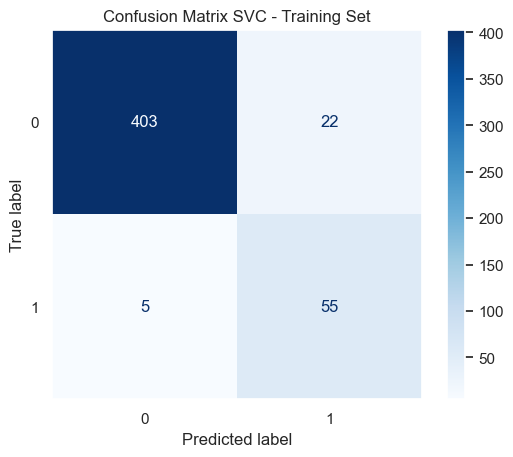

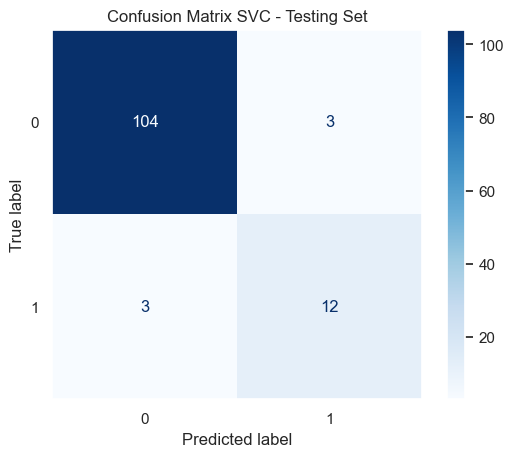

In [56]:
# Confusion matrix for the training set
confusion_display_train = ConfusionMatrixDisplay.from_predictions(y_train, y_pred_svc_train, cmap = plt.cm.Blues)
confusion_display_train.ax_.set_title('Confusion Matrix SVC - Training Set')
plt.grid(False)

# Confusion matrix for the test set
confusion_display_test = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_val_svc, cmap = plt.cm.Blues)
confusion_display_test.ax_.set_title('Confusion Matrix SVC - Testing Set')
plt.grid(False)

## 7. XGBClassifier

In [57]:
xgb = XGBClassifier(reg_lambda = 1, reg_alpha = 0.1, n_estimators = 200, max_depth = 4, learning_rate = 0.01, gamma = 0.8)
model_xgb = xgb.fit(x_train, y_train)
y_pred_xgb_train = model_xgb.predict(x_train)

In [58]:
# Prediction on the test set
y_pred_val_xgb = model_xgb.predict(x_test)
y_pred_proba_val_xgb = model_xgb.predict_proba(x_test)[:, 1]

In [59]:
# Metrics for the test set
accuracy_test = accuracy_score(y_test, y_pred_val_xgb)
report_val = classification_report(y_test, y_pred_val_xgb)
cm_val = confusion_matrix(y_test, y_pred_val_xgb)
roc_auc_val = roc_auc_score(y_test, y_pred_proba_val_xgb)
precision_val = precision_score(y_test, y_pred_val_xgb)
f1_val = f1_score(y_test, y_pred_val_xgb, average = 'weighted')
f2_val = fbeta_score(y_test, y_pred_val_xgb, beta = 2.0)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_val_xgb).ravel()
specificity_test = tn / (tn + fp)
sensitivity_test = tp / (tp + fn)

print("Accuracy:", accuracy_test.round(2))
print("Classification Report:\n", report_val)
print("Confusion Matrix:\n", cm_val)
print("ROC AUC:", roc_auc_val.round(2))
print("Precision:", precision_val.round(2))
print("F1 Score:", f1_val.round(2))
print("F2 Score:", f2_val.round(2))
print("MCC:", mcc_val.round(2))
print("Specificity:", specificity_test.round(2))
print("Sensitivity:", sensitivity_test.round(2)) 

Accuracy: 0.98
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       107
           1       1.00      0.87      0.93        15

    accuracy                           0.98       122
   macro avg       0.99      0.93      0.96       122
weighted avg       0.98      0.98      0.98       122

Confusion Matrix:
 [[107   0]
 [  2  13]]
ROC AUC: 0.96
Precision: 1.0
F1 Score: 0.98
F2 Score: 0.89
MCC: 0.77
Specificity: 1.0
Sensitivity: 0.87


In [60]:
print('Report: training set \n', classification_report(y_train, y_pred_xgb_train))
print('\n Report: test set \n', classification_report(y_test, y_pred_val_xgb))

Report: training set 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       425
           1       0.97      0.93      0.95        60

    accuracy                           0.99       485
   macro avg       0.98      0.96      0.97       485
weighted avg       0.99      0.99      0.99       485


 Report: test set 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       107
           1       1.00      0.87      0.93        15

    accuracy                           0.98       122
   macro avg       0.99      0.93      0.96       122
weighted avg       0.98      0.98      0.98       122



AUC: 0.96


Text(0.5, 1.0, 'XGB Model ROC curve; AUC: 0.96')

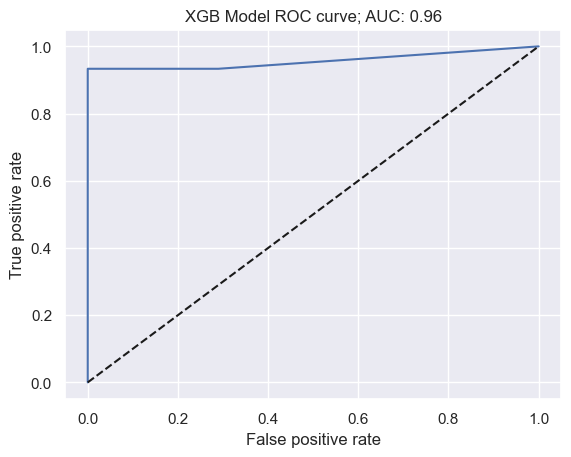

In [61]:
# AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_val_xgb)
auc_xgb = np.round(roc_auc_score(y_test, y_pred_proba_val_xgb), 2)
print("AUC:", auc_xgb) 

sns.set()
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'XGB Model ROC curve; AUC: {auc_xgb}')

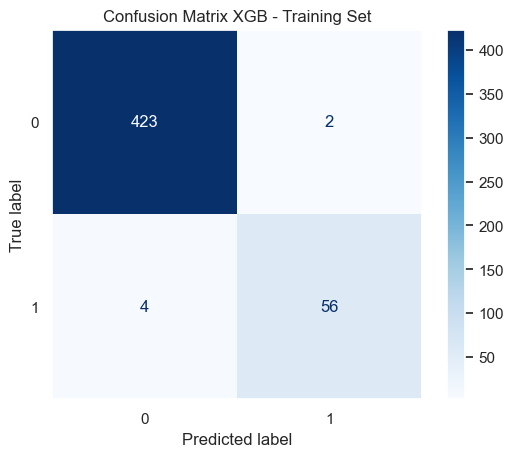

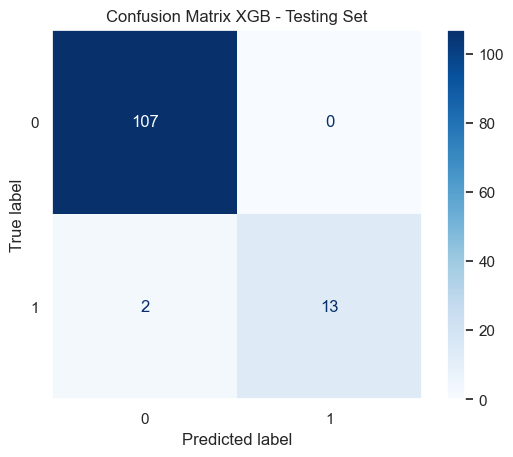

In [62]:
# Confusion matrix for the training set
confusion_display_train = ConfusionMatrixDisplay.from_predictions(y_train, y_pred_xgb_train, cmap = plt.cm.Blues)
confusion_display_train.ax_.set_title('Confusion Matrix XGB - Training Set')
plt.grid(False)

# Confusion matrix for the test set
confusion_display_test = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_val_xgb, cmap = plt.cm.Blues)
confusion_display_test.ax_.set_title('Confusion Matrix XGB - Testing Set')
plt.grid(False)

# Model Comparison - selecting the best model

In [63]:
# Lists of models and predictors
models = ['KNN', 'RF', 'CART', 'NB', 'LogReg', 'SVC', 'XGB']
predictions = [y_pred_val_knn, y_pred_val_rfc, y_pred_val_dtc, y_pred_val_gnb, y_pred_val_lr, y_pred_val_svc, y_pred_val_xgb]

# Lists for results
accuracies = []
auc_scores = []
auprc_scores = []
precisions = []
recalls = []
f1_scores = []
f2_scores = []
specificities = []
sensitivities = []
mcc_scores = []

# Calculate metrics
for pred in predictions:
    accuracy = accuracy_score(y_test, pred)
    accuracies.append(accuracy.round(2))
    auc = roc_auc_score(y_test, pred)
    auc_scores.append(auc.round(2))
    auprc = average_precision_score(y_test, pred)
    auprc_scores.append(auprc.round(2))
    precision = precision_score(y_test, pred)
    precisions.append(precision.round(2))
    recall = recall_score(y_test, pred)
    recalls.append(recall.round(2))
    f1_calculated = f1_score(y_test, pred)
    f1_scores.append(f1_calculated.round(2))
    f2 = fbeta_score(y_test, pred, beta=2.0)
    f2_scores.append(f2.round(2))
    mcc = matthews_corrcoef(y_test, pred)
    mcc_scores.append(mcc.round(2))
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    specificity = tn / (tn + fp)
    specificities.append(specificity.round(2))
    sensitivity = tp / (tp + fn)
    sensitivities.append(sensitivity.round(2))

# DataFrame to display the results
modele_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'AUC': auc_scores,
    'AUPRC': auprc_scores,
    'F1': f1_scores,
    'F2': f2_scores,
    'Specificity': specificities,
    'Sensitivity': sensitivities,
    'MCC': mcc_scores
})

# Sorting for F2
modele_df_sorted = modele_df.sort_values(by = 'F2', ascending = False)

# reset index to start at 1, not 0
modele_df_sorted.index = range(1, len(modele_df_sorted) + 1)

# Displaying results
modele_df_sorted

,Model,Accuracy,Precision,Recall,AUC,AUPRC,F1,F2,Specificity,Sensitivity,MCC
1,RF,0.98,0.93,0.93,0.96,0.88,0.93,0.93,0.99,0.93,0.92
2,CART,0.97,0.82,0.93,0.95,0.78,0.87,0.91,0.97,0.93,0.86
3,XGB,0.98,1.00,0.87,0.93,0.88,0.93,0.89,1.00,0.87,0.92
4,KNN,0.96,0.86,0.80,0.89,0.71,0.83,0.81,0.98,0.80,0.80
5,SVC,0.95,0.80,0.80,0.89,0.66,0.80,0.80,0.97,0.80,0.77
6,LogReg,0.94,0.75,0.80,0.88,0.62,0.77,0.79,0.96,0.80,0.74
7,NB,0.91,0.61,0.73,0.83,0.48,0.67,0.71,0.93,0.73,0.62


## Results:
## According to F2 top3 best models:
## 1. RF
## 2. DT 
## 3. XGB
## Top worst models:
## 1. SVC
## 2. LR
## 3. NB

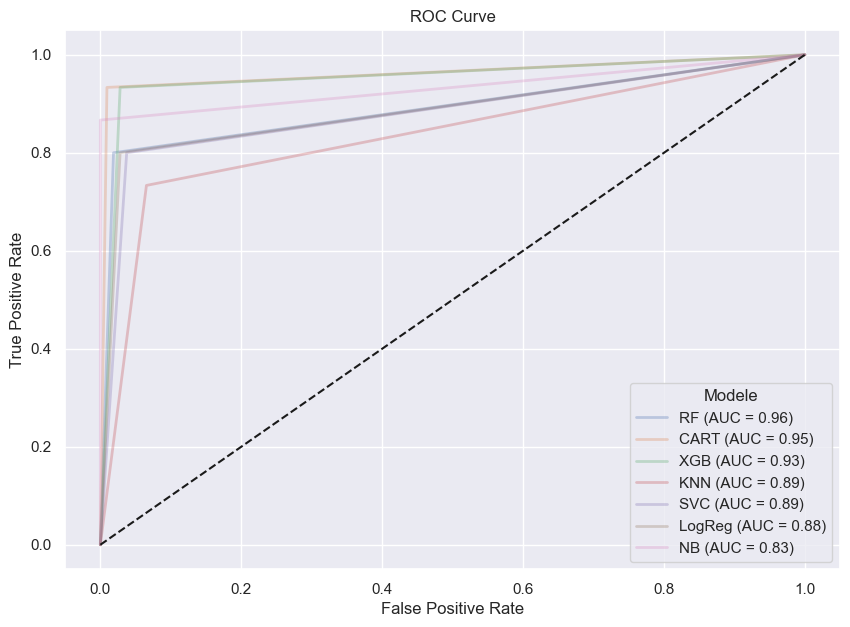

In [64]:
# ROC curves for all models
plt.figure(figsize=(10, 7)) 

# Tuple for storing AUC results and legend tags
legend_labels_and_aucs = []

for model, pred in zip(models, predictions):
    auc = roc_auc_score(y_test, pred)
    auc_scores.append(auc)
    fpr, tpr, _ = roc_curve(y_test, pred)
    plt.plot(fpr, tpr, lw=2, alpha=0.3)
    legend_labels_and_aucs.append((model, auc))

# Sorted legend labels based on AUC score
sorted_legend_labels_and_aucs = sorted(legend_labels_and_aucs, key=lambda x: x[1], reverse=True)
sorted_legend_labels = [f'{x[0]} (AUC = {x[1]:.2f})' for x in sorted_legend_labels_and_aucs]

plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(sorted_legend_labels, title = 'Models', loc = 'lower right')

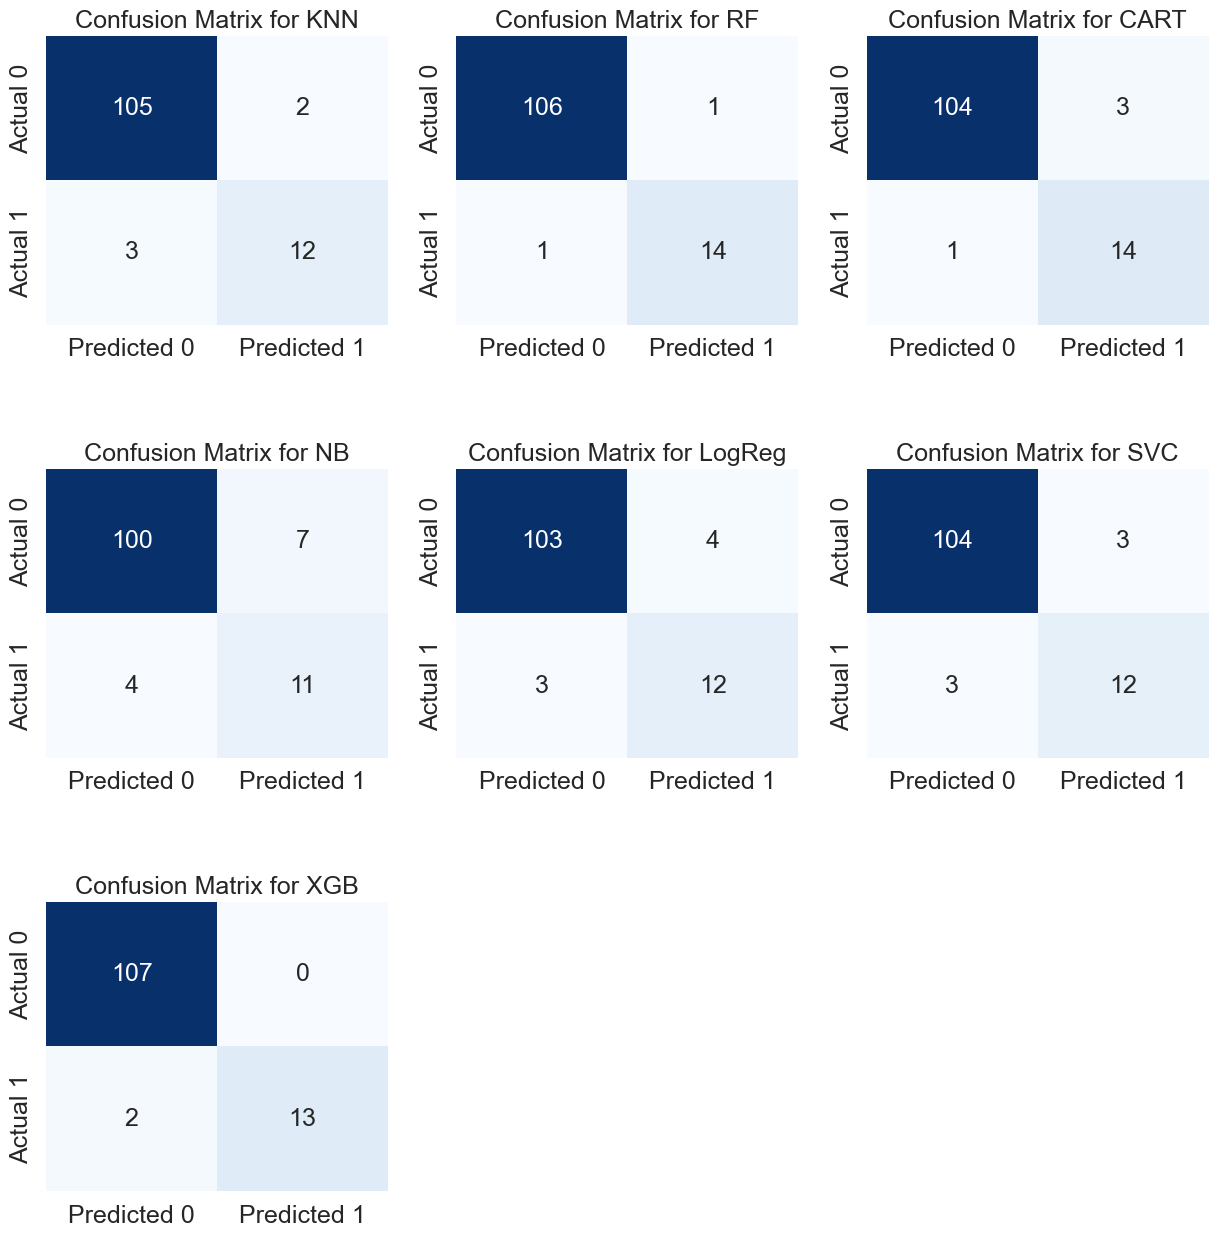

In [65]:
num_models = len(models)
max_matrices_per_row = 3
num_rows = int(np.ceil(num_models / max_matrices_per_row))
num_cols = min(num_models, max_matrices_per_row)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
fig.subplots_adjust(hspace=0.5)

font_size = 18

for i, (model_name, y_pred) in enumerate(zip(models, predictions)):
    row = i // max_matrices_per_row
    col = i % max_matrices_per_row
    cm = confusion_matrix(y_test, y_pred)
    ax = axs[row, col]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'], 
                yticklabels=['Actual 0', 'Actual 1'], ax=ax,
                annot_kws={"size": font_size})
    
    # Set font size for tick labels
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=font_size)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size)
    
    ax.set_title(f'Confusion Matrix for {model_name}', fontsize=font_size)

# Remove any empty subplots if needed
if num_models < (num_rows * max_matrices_per_row):
    for i in range(num_models, num_rows * max_matrices_per_row):
        row = i // max_matrices_per_row
        col = i % max_matrices_per_row
        fig.delaxes(axs[row, col])